**CONSIGNAS PARA TODOS LOS EJERCICIOS:**

1.   En el caso de utilizar una Regresión Logística grafique sus parámetros con la función AA_utils.visualizar_parametros
2.   Grafique e interprete la matriz de confusión de la predicción sobre el set de test con la función AA_utils.visualizar_confusion_matrix
3.   Elabore un reporte de métricas tanto para la predicción de train como para la de test con la función AA_utils.print_classification_report
4.   En los casos de clasificación binaria grafique e interprete la curva ROC con la función AA_utils.visualizar_curva_ROC
5.   En los caso de clasificación de dos variables grafique la función de transferencia y la frontera de decisión con las funciones AA_utils.visualizar_funcion_transferencia_2D y AA_utils.visualizar_frontera_de_desicion_2D
6.   En los casos de clasificación binaria de una variable grafique la curva logística con la función AA_utils.visualizar_curva_logistica

# **TITANIC**

Clasificación Binaria: Compare modelos de Regresión Logística y Redes Neuronales para el siguiente dataset:
*   Titanic.csv. El archivo contiene información de los pasajeros que viajaban. El objetivo es crear un modelo capaz de predecir si un pasajero sobrevive o no al naufragio.

El código “ejemplo_clasificacion_binaria_dos_variables_red_neuronal.py” posee un ejemplo de cómo realizar esta tarea.


In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression

# **AA UTILS**

In [135]:
def if_dataframe_to_numpy(data):
    return data.to_numpy() if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series) else data

def plot_2d(modelo, X, X_train, X_test, y_train, y_test, boundry_function):

    assert X.shape[1] == 2, f"X debe tener solo dos variables de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)
    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    plt.figure()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = np.c_[xx.ravel(), yy.ravel()]
    Z = boundry_function(modelo, Z)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.colorbar()

    plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, label='Training')
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="+", c=y_test, s=80, label='Testing')
    plt.legend()
    plt.show()

def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

def visualizar_parametros(modelo, mostrar_bias, feature_names=[], target_name='target'):
    parametros = pd.DataFrame(modelo.coef_, columns=feature_names if len(feature_names) > 0 else range(modelo.coef_.shape[1]))

    if mostrar_bias:
        parametros['bias'] = modelo.intercept_

    parametros.T.plot(kind='bar')

    if hasattr(modelo, 'classes_'):
        if len(modelo.classes_) <= 2:
            plt.legend([target_name])
        else:
            plt.legend(list(modelo.classes_))
    else:
        plt.legend([target_name])

    plt.show()

def visualizar_curva_logistica(modelo, X, y, feature_name='target'):

    assert X.shape[1] == 1, f"X debe tener solo una variable de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)

    plt.figure()
    plt.scatter(X, y, c=y, s=50)
    plt.xlabel(feature_name)
    plt.grid()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_graph = np.linspace(x_min, x_max)
    y_graph = modelo.predict_proba(x_graph.reshape(-1, 1))[:, 1]
    plt.plot(x_graph, y_graph)
    plt.show()

def visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test):
    plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict(Z))

def visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test):

    if hasattr(modelo, 'predict_proba') and callable(getattr(modelo, 'predict_proba')):
        plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict_proba(Z)[:, 1])
    else:
        raise ValueError("no se puede visualizar funcion de transferencia")

def visualizar_confusion_matrix(real_target, pred_target,
                                classes=[],
                                normalize=False,
                                title='Matriz de confusión',
                                cmap=plt.cm.Blues):

    if (len(classes) == 0):
        classes = [str(i) for i in range(int(max(real_target) + 1))]  # nombres de clases consecutivos

    cm = confusion_matrix(real_target, pred_target)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def visualizar_curva_ROC(modelo, X, y):

    assert len(set(y)) <= 2, f"El dataset debe ser binario (hay {len(set(y))}) clases"

    y_score = modelo.predict_proba(X)[:, 1]  # se queda con la clase 1

    false_positive_rate, true_positive_rate, threshold = roc_curve(y, y_score)

    precision, recall, _ = precision_recall_curve(y, y_score)

    # ROC
    plt.figure()
    plt.title('ROC. Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_score))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
    plt.legend(loc="lower right")
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate (1- Especificidad)')
    plt.show()

    # precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()

def elegir_imagen_al_azar(X, pixeles_ancho, pixeles_alto):
    indice = np.random.randint(0, X.shape[0])
    img_i = np.reshape(X[indice, :], (pixeles_ancho, pixeles_alto))
    plt.figure()
    plt.imshow(img_i, 'gray')
    plt.title('Dato aleatorio')
    plt.show()
    return X[indice].reshape(1, -1), indice

def visualizar_parametros_para_imagenes(modelo, cantidad_de_clases, pixeles_ancho=28, pixeles_alto=28):

    if hasattr(modelo, 'coef_'):
        w = modelo.coef_
    elif hasattr(modelo, 'coefs_') and (modelo.coefs_) == 1:
        w = modelo.coefs_[0]
    else:
        raise "para visualizar los parametros de la red es necesario tener cero capas ocultas"

    colorbar_max = np.abs(np.max(w))
    w_r = np.reshape(w, (cantidad_de_clases, pixeles_ancho, pixeles_alto))
    fig, ax = plt.subplots(2, cantidad_de_clases // 2)
    plt.suptitle('Coeficientes aprendidos para cada clase, \nagrupados en forma matricial de 28x28')
    index = 0
    for row in range(0, 2):
        for col in range(0, cantidad_de_clases // 2):
            colorbar_max = max(np.abs(np.max(w_r[index, :, :])), np.abs(np.min(w_r[index, :, :])))
            ax_im = ax[row][col].imshow(w_r[index, :, :], cmap='seismic', vmin=-colorbar_max, vmax=colorbar_max)
            ax[row][col].get_xaxis().set_visible(False)
            ax[row][col].get_yaxis().set_visible(False)
            ax[row][col].set_title(str(index))
            divider = make_axes_locatable(ax[row][col])
            cax = divider.append_axes("right", size="5%", pad=0.05)

            fig.colorbar(ax_im, ax=ax[row][col], cax=cax)
            index += 1
    plt.show()

def visualizar_ajuste_por_regresion(modelo, X_train, X_test, y_train, y_test,
                                    feature_name='X', target_name='target'):
    plt.scatter(X_train, y_train, c='blue', s=40, alpha=0.9, label='Training')
    plt.scatter(X_test, y_test, c='red', s=50, alpha=0.5, label='Testing')
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.legend()
    plt.grid()

    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    x_max = max(max(X_train), max(X_test))
    x_min = min(min(X_train), min(X_test))

    x_plot = np.linspace(x_min, x_max, 100)
    y_plot = modelo.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, 'g--', linewidth=5)
    plt.show()

def visualizar_curva_error_entrenamiento(modelo):
    plt.plot(modelo.loss_curve_)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(['Train'])
    plt.show()


# **CARGA DE DATOS**

In [136]:
data = pd.read_csv(r"https://raw.githubusercontent.com/KevinFDI/IML_Practica_3/main/Pr%C3%A1ctica/datasets/titanic.csv")

In [137]:
data.columns

Index(['pclass', 'fare', 'age', 'sex', 'sibsp', 'parch', 'survived'], dtype='object')

In [138]:
round(data.describe(), 2)

,pclass,fare,age,sex,sibsp,parch,survived
count,1045.00,1045.00,1045.00,1045.00,1045.00,1045.00,1045.00
mean,2.21,36.69,29.85,0.63,0.50,0.42,0.41
std,0.84,55.73,14.39,0.48,0.91,0.84,0.49
min,1.00,0.00,0.17,0.00,0.00,0.00,0.00
25%,1.00,8.05,21.00,0.00,0.00,0.00,0.00
50%,2.00,15.75,28.00,1.00,0.00,0.00,0.00
75%,3.00,35.50,39.00,1.00,1.00,1.00,1.00
max,3.00,512.33,80.00,1.00,8.00,6.00,1.00


In [139]:
pd.DataFrame(data)

,pclass,fare,age,sex,sibsp,parch,survived
0,1,211.3375,29.0000,0,0,0,1
1,1,151.5500,0.9167,1,1,2,1
2,1,151.5500,2.0000,0,1,2,0
3,1,151.5500,30.0000,1,1,2,0
4,1,151.5500,25.0000,0,1,2,0
...,...,...,...,...,...,...,...
1301,3,7.2250,45.5000,1,0,0,0
1304,3,14.4542,14.5000,0,1,0,0
1306,3,7.2250,26.5000,1,0,0,0
1307,3,7.2250,27.0000,1,0,0,0


**PREPROCESADO**

In [140]:
X = data.drop(columns=["survived"])
y = data["survived"]

print(f'''
      ====================================================================================================
      El problema de clasificación es de {X.shape[1]} features ---(prediciendo)---> {len(set(y))} clases
      ====================================================================================================
      ''')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NORMALIZAR = True

if NORMALIZAR:
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


      El problema de clasificación es de 6 features ---(prediciendo)---> 2 clases
      


# **REDES NEURONALES**

**MODELADO**

In [141]:
modelo = MLPClassifier(hidden_layer_sizes=(20, 5),
                       max_iter=500,
                       tol=1e-4,
                       verbose=True,
                       activation='tanh',
                       learning_rate_init=0.003,
                       solver='adam')
modelo.fit(X_train, y_train)

Iteration 1, loss = 0.84946399
Iteration 2, loss = 0.77895402
Iteration 3, loss = 0.72099883
Iteration 4, loss = 0.67300912
Iteration 5, loss = 0.63458955
Iteration 6, loss = 0.60282562
Iteration 7, loss = 0.57665778
Iteration 8, loss = 0.55595362
Iteration 9, loss = 0.53887014
Iteration 10, loss = 0.52382276
Iteration 11, loss = 0.51141218
Iteration 12, loss = 0.50144000
Iteration 13, loss = 0.49239742
Iteration 14, loss = 0.48532259
Iteration 15, loss = 0.47950442
Iteration 16, loss = 0.47400031
Iteration 17, loss = 0.46942673
Iteration 18, loss = 0.46593874
Iteration 19, loss = 0.46291993
Iteration 20, loss = 0.46119675
Iteration 21, loss = 0.45899068
Iteration 22, loss = 0.45740812
Iteration 23, loss = 0.45596822
Iteration 24, loss = 0.45464400
Iteration 25, loss = 0.45345140
Iteration 26, loss = 0.45225919
Iteration 27, loss = 0.45114080
Iteration 28, loss = 0.45042371
Iteration 29, loss = 0.44967898
Iteration 30, loss = 0.44897629
Iteration 31, loss = 0.44837104
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 5),
              learning_rate_init=0.003, max_iter=500, verbose=True)

**EVALUACION**

**MÉTRICAS SOBRE EL CONJUNTO DE TRAINING**

In [142]:
# 3

print_classification_report(y_train, modelo.predict(X_train))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       491
           1       0.84      0.72      0.77       345

    accuracy                           0.83       836
   macro avg       0.83      0.81      0.82       836
weighted avg       0.83      0.83      0.82       836



**MÉTRICAS SOBRE EL CONJUNTO DE TESTING**

In [143]:
# 3

print_classification_report(y_test, modelo.predict(X_test))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       127
           1       0.82      0.71      0.76        82

    accuracy                           0.82       209
   macro avg       0.82      0.80      0.81       209
weighted avg       0.82      0.82      0.82       209



**MATRIZ DE CONFUSIÓN**

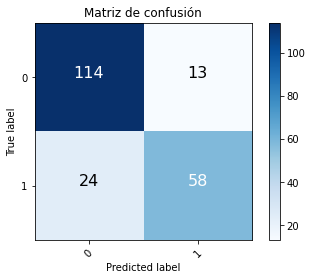

In [144]:
# 2

visualizar_confusion_matrix(y_test, modelo.predict(X_test))

Muestra cómo de relaciona y_predict con y_true

**CURVA DE ROC Y DE PRECISION-RECALL**

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


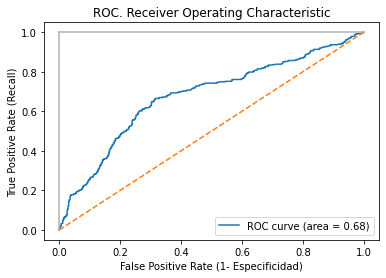

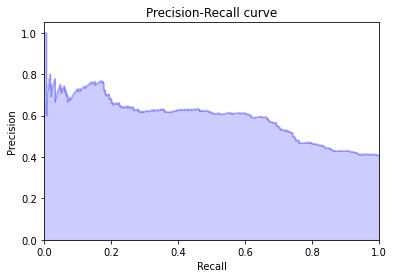

In [145]:
# 4

visualizar_curva_ROC(modelo, X, y)

El area de la curva del ROC indica que el test es regular debido a que se encuentra entre 0.6 - 0.7

**FRONTERA DE DECISIÓN DE DOS DIMENSIONES**

Dado que la variable X tienes muchas columnas, no aplica dicha gráfica (#5).

**FUNCION DE TRANSFERENCIA DE DOS DIMENSIONES**

Dado que la variable X tienes muchas columnas, no aplica dicha gráfica (#5).

La **curva logística** del punto #6 con la función AA_utils.visualizar_curva_logistica no aplica en este ejercicio debido a que el modelo cuenta con mas de una features en la variable X.

**CURVA DE ERROR DE ENTRENAMIENTO**

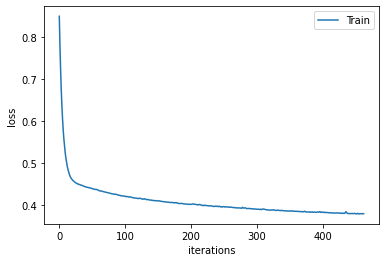

In [146]:
visualizar_curva_error_entrenamiento(modelo)

# **REGRESIÓN LOGÍSTICA**

**MODELADO**

In [147]:
modelo_2 = LogisticRegression()
modelo_2.fit(X_train, y_train)

LogisticRegression()

**EVALUACION**

**MÉTRICAS SOBRE EL CONJUNTO DE TRAINING**

In [148]:
# 3

print_classification_report(y_train, modelo_2.predict(X_train))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       491
           1       0.76      0.70      0.73       345

    accuracy                           0.79       836
   macro avg       0.78      0.77      0.78       836
weighted avg       0.78      0.79      0.78       836



**MÉTRICAS SOBRE EL CONJUNTO DE TESTING**

In [149]:
# 3

print_classification_report(y_test, modelo_2.predict(X_test))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       127
           1       0.71      0.73      0.72        82

    accuracy                           0.78       209
   macro avg       0.77      0.77      0.77       209
weighted avg       0.78      0.78      0.78       209



**MATRIZ DE CONFUSIÓN**

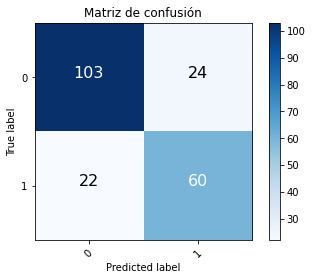

In [150]:
# 2

visualizar_confusion_matrix(y_test, modelo_2.predict(X_test))

**CURVA DE ROC Y DE PRECISION-RECALL**

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


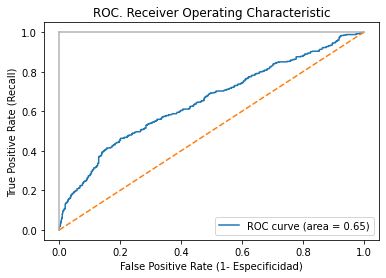

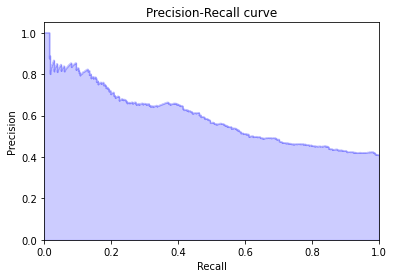

In [151]:
# 4

visualizar_curva_ROC(modelo_2, X, y)

Dado el área de la curva de ROC, se puede clasificar al modelo como regular.

Con esto se observa que **tanto el modelo de redes neuronales como el de regresión logística se comportan de una forma similar**.

**VISUALIZO LOS PARÁMETROS**

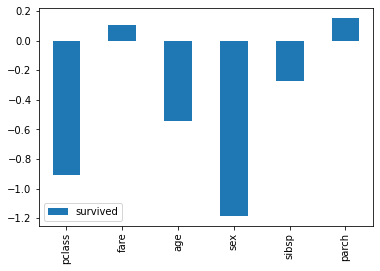

In [152]:
# 1

visualizar_parametros(modelo_2, mostrar_bias=False, feature_names=X.columns, target_name=y.name)

**FRONTERA DE DECISIÓN DE DOS DIMENSIONES**

Dado que la variable X tienes muchas columnas, no aplica dicha gráfica (#5).

**FUNCION DE TRANSFERENCIA DE DOS DIMENSIONES**

Dado que la variable X tienes muchas columnas, no aplica dicha gráfica (#5).

La **curva logística** del punto #6 con la función AA_utils.visualizar_curva_logistica no aplica en este ejercicio debido a que el modelo cuenta con mas de una features en la variable X.